#### Plots

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
from pyspark.sql.functions import col

In [8]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [3]:
%%time
twitter = spark.read.parquet('gs://chen26-bdp/original_data')

CPU times: user 8.75 ms, sys: 1.02 ms, total: 9.77 ms
Wall time: 10.1 s


23/03/07 17:47:53 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [4]:
#tweet location distribution 

In [21]:
t_loc = twitter.select('place')

In [22]:
t_loc = t_loc.filter(col('place').isNotNull())

In [23]:
t_loc.printSchema()

root
 |-- place: struct (nullable = true)
 |    |-- bounding_box: struct (nullable = true)
 |    |    |-- coordinates: array (nullable = true)
 |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |-- element: double (containsNull = true)
 |    |    |-- type: string (nullable = true)
 |    |-- country: string (nullable = true)
 |    |-- country_code: string (nullable = true)
 |    |-- full_name: string (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- place_type: string (nullable = true)
 |    |-- url: string (nullable = true)



In [24]:
t_loc = t_loc.select(t_loc.place.country.alias('country'), t_loc.place.full_name.alias('place'))

In [25]:
t_loc

country,place
Republic of the P...,"Del Carmen, Caraga"
United States,"Louisville, KY"
United States,"Lakeside, FL"
United States,"Duluth, MN"
United States,"Quincy, MA"
United States,"North Carolina, USA"
United States,"Columbus, OH"
United States,"Quincy, MA"
United States,"Mesa, AZ"
United States,"Middletown, RI"


In [26]:
country_ct = t_loc.groupby('country').agg(count('*').alias('count')).orderBy(col('count').desc())

In [27]:
ct = country_ct

country,count
United States,554287
United Kingdom,73793
India,46194
Kingdom of Saudi ...,38942
Canada,24913
Nigeria,24515
Australia,10546
South Africa,10072
المملكة العربية ا...,9248
Kenya,7481


In [32]:
ud = twitter.select(twitter.user.id.alias('user_id'), twitter.user.location.alias('user_loc'))

In [34]:
u_ct = ud.groupby('user_loc').agg(count('*').alias('count')).orderBy(col('count').desc())
u_ct_df = u_ct.limit(10).toPandas()

In [35]:
u_ct_df

,user_loc,count
0,None,39095205
1,United States,1268115
2,"Lagos, Nigeria",521610
3,Nigeria,443069
4,USA,408068
5,India,372519
6,"California, USA",352838
7,"Los Angeles, CA",345411
8,"Texas, USA",314914
9,"Florida, USA",294376


In [36]:
# check the amount of verified users

In [37]:
veri = twitter.select([twitter.user['id'].alias('user_id'),
               twitter.user['verified'].alias('verified')])

In [38]:
verify = veri.filter(col('verified') == 'true')

In [39]:
perc = verify.count()/veri.count()

In [40]:
perc

0.016028286880471698

In [41]:
1-perc

0.9839717131195282

In [42]:
influencer = spark.read.parquet('gs://chen26-bdp/infl')

In [43]:
influencer.orderBy(col('count').desc())

count,user_id,user_name,Max_reach,user_descrip,total_rct
12520,1128225338775953408,AndrianyRahmah,218,hs game update news,13
9201,219401992,DennisStemmle,3804,Founder - College...,410
7769,1508968207259869185,hilmsit,353,𝐋𝐈𝐕𝐄 𝐒𝐓𝐑𝐄...,17
6809,66263683,NJSchoolJobs,4252,The leading adver...,540
6780,1576939116230455296,dini92276801,84,null,6
6609,1577029442488061953,TeriWini,37,null,1
6549,1463182041147576321,sport9920,95,Welcom TV listing...,69
6337,879496394691805184,EssayPaperUK,803,I AM The Documentary,3
6241,1582053513357537293,qiopalika,18,null,3
6178,1473922978073165834,studyinnaija,48,Find All Private ...,5


In [47]:
top50 = influencer.orderBy(col('count').desc()).limit(50).toPandas()

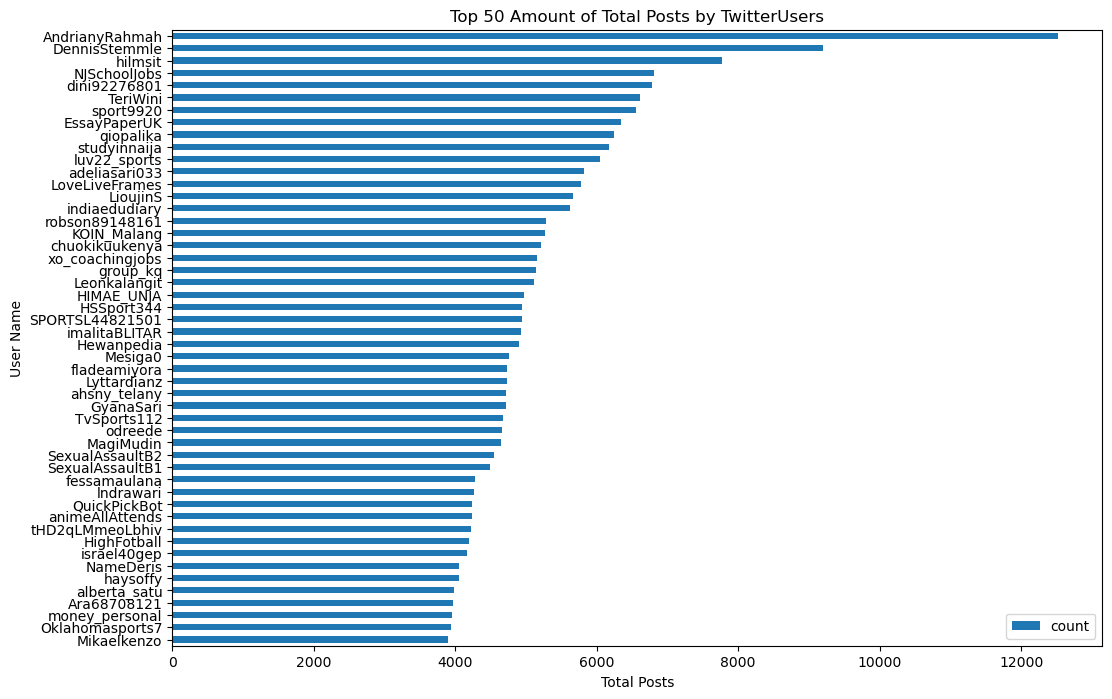

In [48]:
ax = top50.plot(x='user_name', y= 'count', kind='barh', figsize = (12, 8))

ax.set_ylabel('User Name')
ax.set_xlabel('Total Posts')
ax.set_title('Top 50 Amount of Total Posts by TwitterUsers')
ax.invert_yaxis()

# show the plot
plt.show()

In [56]:
top50 = top50.rename(columns={'total_rct': 'total_number_retweets', 'user_descrip': 'Description', 'Max_reach':'followers',
                             'count': 'Total_posts'})


In [58]:
top50

,Total_posts,user_id,user_name,followers,Description,total_number_retweets
0,12520,1128225338775953408,AndrianyRahmah,218,hs game update news,13
1,9201,219401992,DennisStemmle,3804,"Founder - College Success Academy, #1 Best-Selling Author, Entrepreneur, Speaker, Lecturer at The Wall College of Business - Coastal Carolina University",410
2,7769,1508968207259869185,hilmsit,353,𝐋𝐈𝐕𝐄 𝐒𝐓𝐑𝐄𝐀𝐌𝐈𝐍𝐆 🔴 High School Today,17
3,6809,66263683,NJSchoolJobs,4252,The leading advertiser of education jobs for New Jersey's Schools since 1999! #nj #teaching #administrative #coaching #education #teachingjobs #newjersey,540
4,6780,1576939116230455296,dini92276801,84,None,6
5,6609,1577029442488061953,TeriWini,37,None,1
6,6549,1463182041147576321,sport9920,95,"Welcom TV listing for all\nEnjoy your watching live sports - Football,Basketball and more (Click the link below the description)",69
7,6337,879496394691805184,EssayPaperUK,803,I AM The Documentary,3
8,6241,1582053513357537293,qiopalika,18,None,3
9,6178,1473922978073165834,studyinnaija,48,"Find All Private & Public Universities, Colleges and TVETs and Courses Offered in Nigeria.",5


In [59]:
veri = veri.dropDuplicates(['user_id'])

In [60]:
user_veri = influencer.join(veri, influencer.user_id == veri.user_id, 'inner').drop(veri.user_id)

In [ ]:
user_veri

In [63]:
top50_rt = user_veri.orderBy(col('total_rct').desc()).limit(50).toPandas()

In [65]:
top50_rt = top50_rt.rename(columns={'total_rct': 'total_number_retweets', 'user_descrip': 'Description', 'Max_reach':'followers',
                             'count': 'Total_posts'})

In [66]:
top50_rt

,Total_posts,user_id,user_name,followers,Description,total_number_retweets,verified
0,52,1326229737551912960,libsoftiktok,1893691,Bringing you news you won’t see anywhere else. All videos belong to their respective owners. 📧 libsoftiktok@gmail.com. DM submissions,482067,False
1,17,878284831,OccupyDemocrats,504212,Pro-Democrat political organization & news website. NY Times reported that our reach dominated Trump on Facebook before his ban. Founder: @OmarRiverosays,414295,True
2,17,3317348164,NasimiShabnam,71862,Policy Special Advisor to the UK Minister of State for Refugees. Agent: info@theblairpartnership.com 🇬🇧 @TBP_agency,293392,True
3,15,1268223690480615424,NoLieWithBTC,338956,Podcast covering the top stories & interviews with the biggest names in politics. Hosted by @briantylercohen,291413,True
4,10,26257166,SportsCenter,41400369,Download the ESPN App ⬇️,250517,True
5,49,1915033663,davidhogg111,1267103,"Supposedly a “multi-millionaire, American spy, and paid actor” contactdavidhogg@gmail.com",206630,True
6,51,286998245,Phil_Lewis_,300076,detroit native. senior front page editor @huffpost. subscribe to my newsletter! 👇🏾,197817,True
7,1,14335586,Public_Citizen,535244,Public Citizen has been standing up to corporate power and holding government accountable for 50 years. We're people-powered and accept no corporate money.,193203,True
8,1,576320750,JonWTOL,2973,NW Ohio native. Reporter/Photographer for @WTOL11Toledo and @Go_419,185946,True
9,13,1016021178,ColIegeStudent,1876945,Contact: CollegeStudentofficial@gmail.com,181667,False


In [69]:
len(top50_rt[top50_rt['verified'] == True])

28

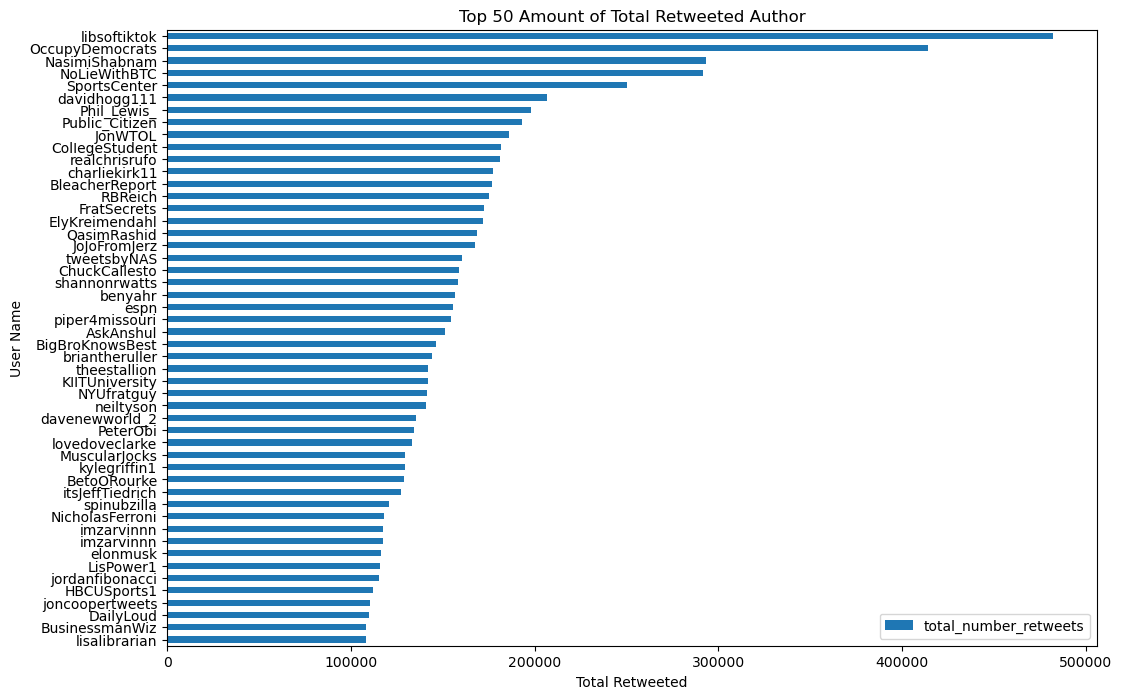

In [71]:
ax = top50_rt.plot(x='user_name', y= 'total_number_retweets', kind='barh', figsize = (12, 8))

ax.set_ylabel('User Name')
ax.set_xlabel('Total Retweeted')
ax.set_title('Top 50 Amount of Total Retweeted Author')
ax.invert_yaxis()

# show the plot
plt.show()

In [72]:
user_veri = user_veri.withColumn('t_avg_reach', col('total_rct')/col('count'))\
                      .withColumn('inf_score', col('t_avg_reach')*col('Max_reach'))

In [73]:
user_veri

count,user_id,user_name,Max_reach,user_descrip,total_rct,verified,t_avg_reach,inf_score
2,418,dens,83191,I like to build t...,10,true,5.0,415955.0
1,7499,Naija,4668,We handle what ma...,3,false,3.0,14004.0
4,10078,reidhoffman,652434,Entrepreneur. Inv...,38,true,9.5,6198123.0
1,10178,stoweboyd,19020,"The past, present...",2,false,2.0,38040.0
4,10237,Chuckumentary,10314,boreal human with...,2,false,0.5,5157.0
6,40403,rosemary,1235,Design web etc at...,2,false,0.3333333333333333,411.66666666666663
4,41243,adliterate,12719,High octane brand...,3,false,0.75,9539.25
2,60033,andybudd,65955,"Design Founder, s...",8,false,4.0,263820.0
7,77983,pickwick,2167,leftie feminist s...,10,false,1.4285714285714286,3095.714285714286
9,618373,superflippy,3264,I believe art & s...,1,false,0.1111111111111111,362.66666666666663


In [ ]:
topinf = user_veri.orderBy(col('inf_score').desc()).limit(50).toPandas()

In [75]:
topinf

,count,user_id,user_name,Max_reach,user_descrip,total_rct,verified,t_avg_reach,inf_score
0,1,44196397,elonmusk,106476100,None,116620,True,116620.000000,1.241724e+13
1,3,18839785,narendramodi,84850082,Prime Minister of India,80295,True,26765.000000,2.271012e+12
2,1,19725644,neiltyson,14805242,Astrophysicist,140754,True,140754.000000,2.083897e+12
3,1,23375688,selenagomez,65889944,REVELACIÓN out now: http://smarturl.it/REVELACIONSG,25761,True,25761.000000,1.697391e+12
4,1,1339835893,HillaryClinton,31426778,"2016 Democratic Nominee, SecState, Senator, hair icon. Mom, Wife, Grandma x3, lawyer, advocate, fan of walks in the woods & standing up for our democracy.",48751,True,48751.000000,1.532087e+12
5,1,122453931,ImranKhanPTI,17789483,Chairman Pakistan Tehreek-e-Insaf & former Prime Minister of Islamic Republic of Pakistan,65561,True,65561.000000,1.166296e+12
6,1,104040220,theestallion,7600799,thee real Htown Hottie 😛,142205,True,142205.000000,1.080872e+12
7,10,26257166,SportsCenter,41400369,Download the ESPN App ⬇️,250517,True,25051.700000,1.037150e+12
8,4,1349149096909668363,POTUS,29370914,"46th President of the United States, husband to @FLOTUS, proud dad & pop. Tweets may be archived: http://whitehouse.gov/privacy\nText me: (302) 404-0880",92863,True,23215.750000,6.818678e+11
9,2,216776631,BernieSanders,15731059,"U.S. Senator for Vermont. Not me, us.",84233,True,42116.500000,6.625371e+11


In [78]:
topinf = topinf.rename(columns={'total_rct': 'Total_Number_Retweets', 'user_descrip': 'Description', 'Max_reach':'Followers',
                             'count': 'Total_Posts', 't_avg_reach': 'Average_Reach', 'inf_score': 'Influence_Score'})

In [79]:
topinf

,Total_posts,user_id,user_name,followers,Description,total_number_retweets,verified,Average_Reach,Influence_Score
0,1,44196397,elonmusk,106476100,None,116620,True,116620.000000,1.241724e+13
1,3,18839785,narendramodi,84850082,Prime Minister of India,80295,True,26765.000000,2.271012e+12
2,1,19725644,neiltyson,14805242,Astrophysicist,140754,True,140754.000000,2.083897e+12
3,1,23375688,selenagomez,65889944,REVELACIÓN out now: http://smarturl.it/REVELACIONSG,25761,True,25761.000000,1.697391e+12
4,1,1339835893,HillaryClinton,31426778,"2016 Democratic Nominee, SecState, Senator, hair icon. Mom, Wife, Grandma x3, lawyer, advocate, fan of walks in the woods & standing up for our democracy.",48751,True,48751.000000,1.532087e+12
5,1,122453931,ImranKhanPTI,17789483,Chairman Pakistan Tehreek-e-Insaf & former Prime Minister of Islamic Republic of Pakistan,65561,True,65561.000000,1.166296e+12
6,1,104040220,theestallion,7600799,thee real Htown Hottie 😛,142205,True,142205.000000,1.080872e+12
7,10,26257166,SportsCenter,41400369,Download the ESPN App ⬇️,250517,True,25051.700000,1.037150e+12
8,4,1349149096909668363,POTUS,29370914,"46th President of the United States, husband to @FLOTUS, proud dad & pop. Tweets may be archived: http://whitehouse.gov/privacy\nText me: (302) 404-0880",92863,True,23215.750000,6.818678e+11
9,2,216776631,BernieSanders,15731059,"U.S. Senator for Vermont. Not me, us.",84233,True,42116.500000,6.625371e+11


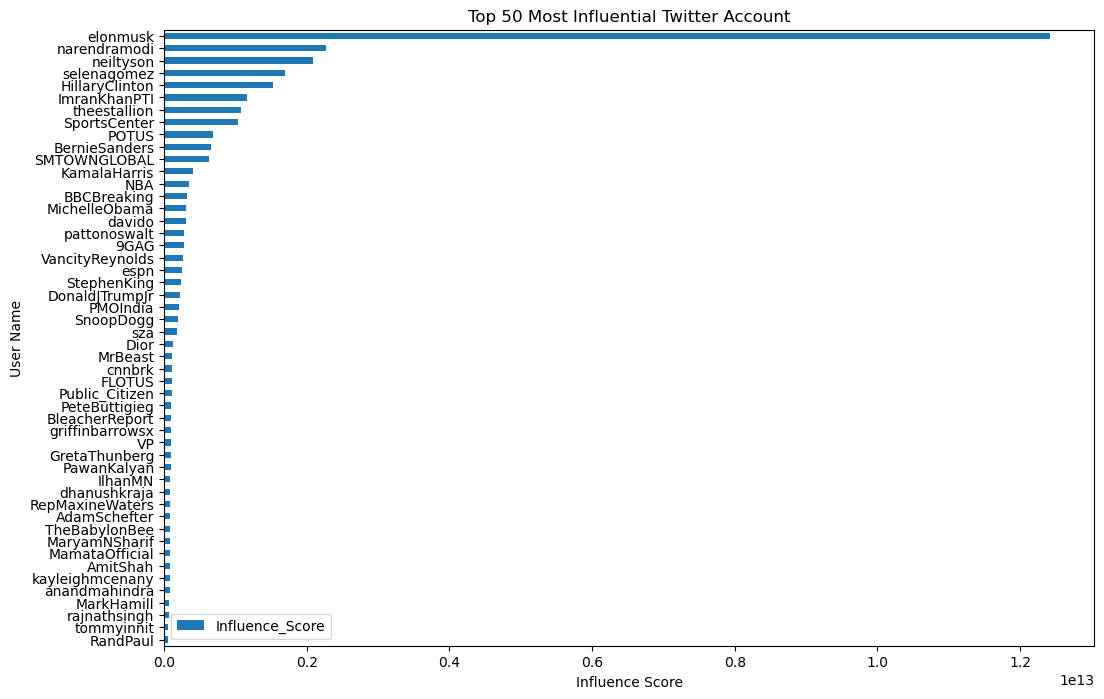

In [80]:
ax = topinf.plot(x='user_name', y= 'Influence_Score', kind='barh', figsize = (12, 8))

ax.set_ylabel('User Name')
ax.set_xlabel('Influence Score')
ax.set_title('Top 50 Most Influential Twitter Account')
ax.invert_yaxis()

# show the plot
plt.show()